# Stage 2 Preprocessing

In [54]:
# load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [55]:
# read file csv into dataframe
df = pd.read_csv('Travel.csv')

# view first 5 rows of data
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [56]:
# view info attributes and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

## EDA Conclusion

Dari hasil EDA yang telah dilakukan sebelumnya diketahui bahwa :
1. Nama kolom dan tipe data sudah sesuai, tetapi ada kesalahan data pada kolom `Gender` dan kesamaan makna data pada kolom `Marital Status`.
2. Terdapat *missing values* pada kolom `Age`, `DurationOfPitch`, `NumberOfFollowups`, `PreferredPropertyStar`, `NumberOfTrips`, `NumberOfChildrenVisiting`, `MonthlyIncome`, dan `TypeofContact`.
3. Terdapat outlier pada kolom `DurationOfPitch, NumberOfTrips, MonthlyIncome`.
4. Telah ditemukan baris yang duplikat pada dataset yang digunakan.
5. Kolom `CustomerID` bisa dihapus karena setiap baris memiliki customer id yang berbeda-beda.
6. Kolom `ProdTaken` adalah target yang akan diprediksi.
7. Kolom numerik yang terlihat memiliki korelasi terhadap target dapat digunakan sebagai fitur, yaitu `Age`, `MontlyIncome`, `NumberOfFollowups` dan `Passport`.
8. Kolom `NumberOfPersonVisiting` dan `NumberOfChildrenVisiting` memiliki korelasi positif cukup kuat sehingga bisa digabung untuk menjadi fitur baru (`TotalVisiting`).
9. Beberapa kolom numerik yang terlihat sama sekali tidak berkorelasi terdapat target dapat dihapus.
10. Pada kolom kategorik bisa dimasukkan fitur, yaitu `TypeofContact`, `Occupation`, `Gender`, `ProductPitched`, `MaritalStatus`, dan `Designation`

## Data Cleansing

In [57]:
df_prep = df.copy()

### Handling Inconsistent Data

In [58]:
df_prep['Gender'] = df_prep['Gender'].replace('Fe Male', 'Female')
df_prep['MaritalStatus'] = df_prep['MaritalStatus'].replace('Single', 'Unmarried')

print('Gender :', df_prep['Gender'].unique().tolist())
print('Marital Status:', df_prep['MaritalStatus'].unique().tolist())

Gender : ['Female', 'Male']
Marital Status: ['Unmarried', 'Divorced', 'Married']


### Handling Missing Values

In [59]:
# counts missing data
missing_cols = df_prep.columns[df_prep.isnull().any()]
df_prep[missing_cols].isnull().sum()

Age                         226
TypeofContact                25
DurationOfPitch             251
NumberOfFollowups            45
PreferredPropertyStar        26
NumberOfTrips               140
NumberOfChildrenVisiting     66
MonthlyIncome               233
dtype: int64

In [60]:
# statistics on numerical columns (missing cols)
df_prep[missing_cols].select_dtypes(exclude='object').describe()

,Age,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome
count,4662.000000,4637.000000,4843.000000,4862.000000,4748.000000,4822.000000,4655.000000
mean,37.622265,15.490835,3.708445,3.581037,3.236521,1.187267,23619.853491
std,9.316387,8.519643,1.002509,0.798009,1.849019,0.857861,5380.698361
min,18.000000,5.000000,1.000000,3.000000,1.000000,0.000000,1000.000000
25%,31.000000,9.000000,3.000000,3.000000,2.000000,1.000000,20346.000000
50%,36.000000,13.000000,4.000000,3.000000,3.000000,1.000000,22347.000000
75%,44.000000,20.000000,4.000000,4.000000,4.000000,2.000000,25571.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,3.000000,98678.000000


In [61]:
# statistics on categorical columns (missing cols)
df_prep[missing_cols].select_dtypes(include='object').describe()

,TypeofContact
count,4863
unique,2
top,Self Enquiry
freq,3444


Dari pengamatan yang sudah dilakukan saat EDA maka penanganan missing values yang digunakan, yaitu:
- Kolom `Age` akan diisi dengan nilai mean (disribusi data mendekati normal).
- Kolom `TypeofContact` akan diisi dengan nilai 'Unknown' (nilai modus sudah terlalu tinggi).
- Kolom `DurationOfPitch` akan disi dengan nilai median (distribusi data mengandung outlier karena skewed).
- Kolom `NumberOfFollowups` akan disi dengan nilai min (dianggap tidak ada follow up setelah pitching).
- Kolom `PreferredPropertyStar` akan diisi dengan nilai 3 (nilai rating yang moderate).
- Kolom `NumberOfTrips` akan disi dengan nilai median (distribusi data mengandung outlier karena skewed).
- Kolom `NumberOfChildrenVisiting` akan diisi dengan nilai 0 (dianggap tidak memiliki anak dibawah 5 tahun).
- Kolom `MonthlyIncome` akan disi dengan nilai median (distribusi data mengandung outlier karena skewed).

In [62]:
# handling missing values
df_prep['Age'].fillna(df_prep['Age'].mean(), inplace=True)
df_prep['TypeofContact'].fillna('Unknown', inplace=True)
df_prep['DurationOfPitch'].fillna(df_prep['DurationOfPitch'].median(), inplace=True)
df_prep['NumberOfFollowups'].fillna(0, inplace=True)
df_prep['PreferredPropertyStar'].fillna(3, inplace=True)
df_prep['NumberOfTrips'].fillna(df_prep['NumberOfTrips'].median(), inplace=True)
df_prep['NumberOfChildrenVisiting'].fillna(0, inplace=True)
df_prep['MonthlyIncome'].fillna(df_prep['MonthlyIncome'].median(), inplace=True)

In [63]:
# check again if any missing values
print('Apakah masih terdapat kolom dengan nilai null/missing values?', df_prep.isnull().any().any())

Apakah masih terdapat kolom dengan nilai null/missing values? False


### Handling Duplicate Data

In [64]:
# remove CustomerID to see duplicate rows
df_prep.drop('CustomerID', axis=1, inplace=True)
print(f'Jumlah baris sebelum difilter duplikat data adalah {df_prep.shape[0]}')

# remove duplicate rows
df_prep.drop_duplicates(inplace=True)
print(f'Jumlah baris setelah difilter duplikat data adalah {df_prep.shape[0]}')

Jumlah baris sebelum difilter duplikat data adalah 4888
Jumlah baris setelah difilter duplikat data adalah 4747


### Handling Outlier

In [65]:
# view total rows before filtered
print(f'Jumlah baris sebelum memfilter outlier adalah {df_prep.shape[0]}')

# handle outlier using z-score
filtered_entries = np.array([True] * len(df_prep))
skewed_cols = ['DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']
for col in skewed_cols:
    zscore = abs(stats.zscore(df_prep[col]))
    filtered_entries = (zscore < 3) & filtered_entries    

# view total rows after filtered
df_prep = df_prep[filtered_entries]
print(f'Jumlah baris setelah memfilter outlier adalah {df_prep.shape[0]}')

Jumlah baris sebelum memfilter outlier adalah 4747
Jumlah baris setelah memfilter outlier adalah 4737


### Feature Transformation

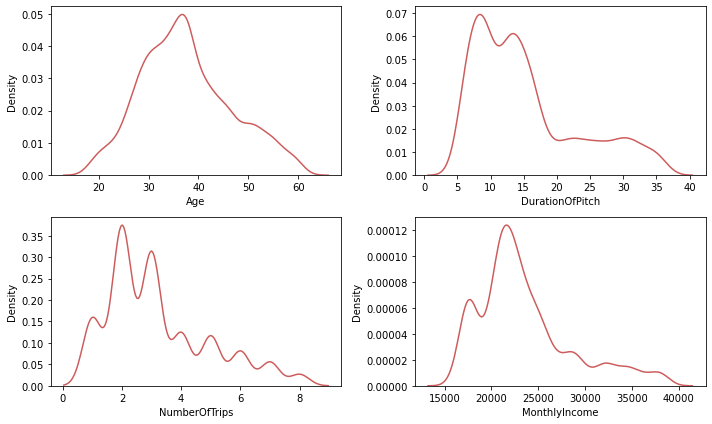

In [66]:
# distribution of data before scaling
plt.figure(figsize=(10, 6))
for i, col in enumerate(['Age', 'DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df_prep[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

Berdasarkan hasil visualiasi tersebut, maka:
- Kolom `Age` akan dilakukan scaling dengan Normalization karena mendekati distribusi normal.
- Kolom `NumberOfTrips` tidak dilakukan scaling karena nilai datanya tidak terlalu variatif setelah dihandling outlier.
- Kolom `DurationOfPitch` dan `MonthlyIncome` akan dilakukan scaling dengan Standardization karena sedikit skewed.

In [67]:
# scaling using normalization
df_prep['Age'] = MinMaxScaler().fit_transform(df_prep['Age'].values.reshape(-1, 1))
# scaling using standardization
df_prep['DurationOfPitch'] = StandardScaler().fit_transform(df_prep['DurationOfPitch'].values.reshape(-1, 1))
df_prep['MonthlyIncome'] = StandardScaler().fit_transform(df_prep['MonthlyIncome'].values.reshape(-1, 1))

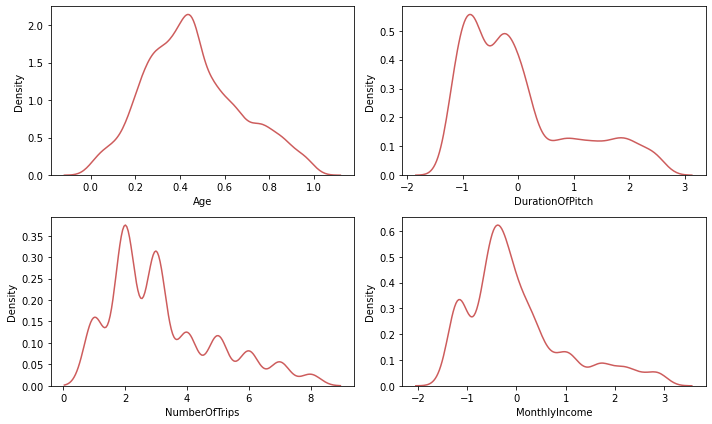

In [68]:
# distribution of data after scaling
plt.figure(figsize=(10, 6))
for i, col in enumerate(['Age', 'DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df_prep[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [69]:
# statistics data after transformation
df_prep[['Age', 'DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']].describe()

,Age,DurationOfPitch,NumberOfTrips,MonthlyIncome
count,4737.000000,4.737000e+03,4737.000000,4.737000e+03
mean,0.455493,-1.145613e-16,3.211948,-1.453804e-15
std,0.212082,1.000106e+00,1.751640,1.000106e+00
min,0.000000,-1.289734e+00,1.000000,-1.494390e+00
25%,0.302326,-7.908081e-01,2.000000,-6.049141e-01
50%,0.441860,-2.918825e-01,3.000000,-2.340508e-01
75%,0.581395,4.565059e-01,4.000000,3.706653e-01
max,1.000000,2.576940e+00,8.000000,3.013241e+00


Dari hasil statistik tersebut diketahui bahwa:
- Kolom `Age` memiliki nilai min = 0 dan nilai max = 0 setelah dilakukan normalisasi.
- Kolom `NumberOfTrips` memiliki nilai min = 1 dan nilai max = 8 dianggap tidak terlalu variatif range datanya. 
- Kolom `DurationOfPitch` dan `MonthlyIncome` memiliki nilai mean = -1 dan nilai standar deviasi = 1 setelah dilakukan standardisasi

### Feature Encoding

In [70]:
# view unique values on categorical columns
for col in df_prep.select_dtypes(include='object').columns:
    print(f'{col} : {df_prep[col].unique().tolist()}')
    print(df_prep[col].value_counts())
    print('------------------------------------------')

TypeofContact : ['Self Enquiry', 'Company Invited', 'Unknown']
Self Enquiry       3346
Company Invited    1366
Unknown              25
Name: TypeofContact, dtype: int64
------------------------------------------
Occupation : ['Salaried', 'Free Lancer', 'Small Business', 'Large Business']
Salaried          2287
Small Business    2028
Large Business     420
Free Lancer          2
Name: Occupation, dtype: int64
------------------------------------------
Gender : ['Female', 'Male']
Male      2829
Female    1908
Name: Gender, dtype: int64
------------------------------------------
ProductPitched : ['Deluxe', 'Basic', 'Standard', 'Super Deluxe', 'King']
Basic           1794
Deluxe          1680
Standard         714
Super Deluxe     324
King             225
Name: ProductPitched, dtype: int64
------------------------------------------
MaritalStatus : ['Unmarried', 'Divorced', 'Married']
Married      2277
Unmarried    1512
Divorced      948
Name: MaritalStatus, dtype: int64
--------------------

Dari hasil tersebut maka dapat disimpulkan bahwa:
- Pada kolom `Occupation` terlihat jumlah customer 'Free Lancer' terlalu sedikit sehingga dapat dihapus.
- Kolom `Gender` memiliki *unique values* berjumlah 2 maka dapat dilakukan Label Encoding.
- Kolom `ProductPitched` dan `Designation` memiliki *unique values* berjenis data ordinal maka dapat dilakukan Label Encoding.
- Kolom `TypeofContact`, `Occupation`, dan `MaritalStatus` memiliki unique values lebih dari 2 dan tidak berjenis data ordinal sehingga dilakukan One Hot Encoding.

In [71]:
# remove rows with Occupation is `Free Lancer`
df_prep = df_prep[df_prep['Occupation']!='Free Lancer']

# view dimension size of data before encoding
print(f'Dimensi data sebelum encoding adalah {df_prep.shape[0]} baris dan {df_prep.shape[1]} kolom')

# label encoding
df_prep['Gender'] = df_prep['Gender'].map({'Female':0, 'Male':1})
df_prep['ProductPitched'] = df_prep['ProductPitched'].map({'Basic':0, 'Standard':1, 'Deluxe':2,
                                                           'Super Deluxe':3, 'King':4})
df_prep['Designation'] = df_prep['Designation'].map({'Manager':0, 'Senior Manager':1, 'Executive':2,
                                                     'AVP':3, 'VP':4})

# one hot encoding
for col in ['TypeofContact', 'Occupation', 'MaritalStatus']:
    onehots = pd.get_dummies(df_prep[col], prefix=col)
    df_prep = pd.concat([df_prep, onehots], axis=1)
    df_prep.drop(columns=col, axis=1, inplace=True)
    
# view dimension size of data before encoding
print(f'Dimensi data setelah encoding adalah {df_prep.shape[0]} baris dan {df_prep.shape[1]} kolom')

Dimensi data sebelum encoding adalah 4735 baris dan 19 kolom
Dimensi data setelah encoding adalah 4735 baris dan 25 kolom


### Handling Imbalance Class

In [72]:
# check proportion class before balancing
df_prep['ProdTaken'].value_counts()

0    3845
1     890
Name: ProdTaken, dtype: int64

In [73]:
from sklearn.model_selection import train_test_split

# handling imbalance class
X = df_prep.drop('ProdTaken', axis=1)
y = df_prep['ProdTaken']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_smote, y_smote = SMOTE(0.5).fit_resample(X_train, y_train)

# check proportion class after balancing
print(y_smote.value_counts())

0    2684
1    1342
Name: ProdTaken, dtype: int64


## Feature Engineering

### Feature Extraction

In [74]:
# get correlation > +- 0.5
df_corr = df_prep.corr().iloc[1:,1:]
df_corr = df_corr.apply(lambda x: round(x, 3))
dfcorr=[]
for idx in df_corr.index:
    for col in df_corr.columns:
        dfcorr.append(idx +' with '+ col)
        if (np.abs(df_corr.loc[idx, col]) > 0.5)  and (idx != col) and (col +' with '+idx) not in dfcorr:
            print(f'{idx} with {col} has correlation : {df_corr.loc[idx, col]}')

NumberOfPersonVisiting with NumberOfChildrenVisiting has correlation : 0.595
ProductPitched with MonthlyIncome has correlation : 0.678
TypeofContact_Company Invited with TypeofContact_Self Enquiry has correlation : -0.987
Occupation_Salaried with Occupation_Small Business has correlation : -0.837
MaritalStatus_Married with MaritalStatus_Unmarried has correlation : -0.659


In [75]:
# create new column for feature
df_prep['TotalVisiting'] = df_prep['NumberOfPersonVisiting'] + df_prep['NumberOfChildrenVisiting']
df_prep.drop(columns=['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis=1, inplace=True)

 ### Feature Selection

In [76]:
# check correlation to target
df_prep.corr()['ProdTaken'].iloc[1:]

Age                             -0.142819
CityTier                         0.088483
DurationOfPitch                  0.080149
Gender                           0.029351
NumberOfFollowups                0.108264
ProductPitched                  -0.218802
PreferredPropertyStar            0.096755
NumberOfTrips                    0.020386
Passport                         0.261313
PitchSatisfactionScore           0.051937
OwnCar                          -0.010679
Designation                      0.074768
MonthlyIncome                   -0.130784
TypeofContact_Company Invited    0.042052
TypeofContact_Self Enquiry      -0.039811
TypeofContact_Unknown           -0.012674
Occupation_Large Business        0.070456
Occupation_Salaried             -0.032312
Occupation_Small Business       -0.007851
MaritalStatus_Divorced          -0.073203
MaritalStatus_Married           -0.123330
MaritalStatus_Unmarried          0.195070
TotalVisiting                    0.012477
Name: ProdTaken, dtype: float64

In [77]:
# select features correlation > 0.1
features_cols = []
for i,val in enumerate(df_prep.corr()['ProdTaken'].iloc[1:]):
    if np.abs(val) > 0.1:
        features_cols.append(df_prep.iloc[:,1:].columns[i])
features_cols

['Age',
 'NumberOfFollowups',
 'ProductPitched',
 'Passport',
 'MonthlyIncome',
 'MaritalStatus_Married',
 'MaritalStatus_Unmarried']

In [78]:
# select features with chi square test
chi2_check = []
check_cols = ['CityTier', 'Gender', 'NumberOfFollowups', 'ProductPitched', 
              'PreferredPropertyStar','Passport', 'PitchSatisfactionScore', 'OwnCar',
              'Designation', 'TypeofContact_Company Invited',
              'TypeofContact_Self Enquiry', 'TypeofContact_Unknown', 
              'Occupation_Large Business', 'Occupation_Salaried',
              'Occupation_Small Business', 'MaritalStatus_Divorced',
              'MaritalStatus_Married', 'MaritalStatus_Unmarried']
for i in check_cols:
    if stats.chi2_contingency(pd.crosstab(df_prep['ProdTaken'], df_prep[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
result = pd.DataFrame(data=[check_cols, chi2_check]).T
result.columns = ['Column', 'Hypothesis Result']
result

,Column,Hypothesis Result
0,CityTier,Reject Null Hypothesis
1,Gender,Reject Null Hypothesis
2,NumberOfFollowups,Reject Null Hypothesis
3,ProductPitched,Reject Null Hypothesis
4,PreferredPropertyStar,Reject Null Hypothesis
5,Passport,Reject Null Hypothesis
6,PitchSatisfactionScore,Reject Null Hypothesis
7,OwnCar,Fail to Reject Null Hypothesis
8,Designation,Reject Null Hypothesis
9,TypeofContact_Company Invited,Reject Null Hypothesis


In [79]:
chi2_result = result[result['Hypothesis Result']=='Reject Null Hypothesis']['Column'].values.tolist()
fix_cols = features_cols
for col in chi2_result:
    if col not in features_cols:
        fix_cols.append(col)
fix_cols

['Age',
 'NumberOfFollowups',
 'ProductPitched',
 'Passport',
 'MonthlyIncome',
 'MaritalStatus_Married',
 'MaritalStatus_Unmarried',
 'CityTier',
 'Gender',
 'PreferredPropertyStar',
 'PitchSatisfactionScore',
 'Designation',
 'TypeofContact_Company Invited',
 'TypeofContact_Self Enquiry',
 'Occupation_Large Business',
 'Occupation_Salaried',
 'MaritalStatus_Divorced']

4 Feature yang mungkin dapat ditambahkan jika terdapat datanya:
- DayByTrips (Rata-rata lama liburan tiap perjalanan)
- HistoryCancel (Berapa banyak perjalanan yang pernah dibatalkan)
- Discount (Rata-rata diskon yang didapatkan tiap pembelian paket perjalanan)
- Spending (Total pembelian paket selama setahun)